In [32]:
import numpy as np
from sklearn import preprocessing
#import tensorflow as tf
import pandas as pd


In [33]:
data=pd.read_csv("df_merged.csv")
data

,Power Building,day,Hour,month,minute
0,38.394,31,23,12,45
1,38.619,31,23,12,30
2,38.577,31,23,12,15
3,38.493,31,23,12,0
4,38.313,31,22,12,45
...,...,...,...,...,...
26262,51.912,1,1,4,0
26263,50.980,1,0,4,45
26264,51.873,1,0,4,30
26265,51.186,1,0,4,15


In [34]:
#X = np.asarray(data[["Hour", "day","minute","month"]])
#X[0:5]

In [35]:
#Ymin = np.asarray([data["Power Building"].min()])
#Ymax = np.asarray([data["Power Building"].max()])

In [36]:
#X = preprocessing.MinMaxScaler().fit(X).transform(X.astype(float))
#X[0:5]

In [37]:
#Y= np.asarray(round(data["Power Building"],1))

#Y[0:5]

In [38]:
#Y = preprocessing.StandardScaler().fit(Y.reshape(-1, 1)).transform(Y.reshape(-1, 1).astype(float))
#Y[0:5]

In [39]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split( X, Y,test_size=0.2, random_state=4)
#print ('Train set:', X_train.shape,  Y_train.shape)
#print ('Test set:', X_test.shape,  Y_test.shape)

In [40]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt


In [41]:
import datetime

# Combina las columnas en una cadena de fecha
data['timestamp_str'] = data['day'].astype(str) + '-' + data['month'].astype(str) + '-2019 ' + data['Hour'].astype(str) + ':' + data['minute'].astype(str)

# Convierte la cadena de fecha a un objeto de fecha y hora
data['timestamp'] = pd.to_datetime(data['timestamp_str'], format='%d-%m-%Y %H:%M')

# Opcional: Puedes eliminar las columnas temporales creadas
data = data.drop(['day', 'Hour', 'month', 'minute', 'timestamp_str'], axis=1)

In [42]:
data['timestamp_numeric'] = data['timestamp'].apply(lambda x: x.timestamp())

data = data.drop(["timestamp"], axis=1)

In [43]:
total_filas = data.shape[0]

porcentaje_entrenamiento = 0.8

# Calcula el número de filas para entrenamiento y prueba
num_filas_entrenamiento = int(total_filas * porcentaje_entrenamiento)
num_filas_prueba = total_filas - num_filas_entrenamiento

# Divide los datos
X_train = data["timestamp_numeric"][:num_filas_entrenamiento]
Y_train = data["Power Building"][:num_filas_entrenamiento]

X_test = data["timestamp_numeric"][num_filas_entrenamiento:]
Y_test = data["Power Building"][num_filas_entrenamiento:]

print('Train set:', X_train.shape, Y_train.shape)
print('Test set:', X_test.shape, Y_test.shape)

Train set: (21013,) (21013,)
Test set: (5254,) (5254,)


In [44]:
X_train_array = X_train.to_numpy()
Y_train_array = Y_train.to_numpy()

# Luego, puedes crear el DataFrame
df = pd.DataFrame({'timestamp_numeric': X_train_array.flatten(), 'Power Building': Y_train_array.flatten()})

In [45]:
s1=MinMaxScaler(feature_range=(-1,1))
Xs=s1.fit_transform(df[["timestamp_numeric"]])

s2=MinMaxScaler(feature_range=(-1,1))
Ys=s2.fit_transform(df[["Power Building"]])

In [46]:
window=70
X=[]
Y=[]
for i in range(window, len(Xs)):
    X.append(Xs[i-window:i,:])
    Y.append(Ys[i])
X,Y=np.array(X), np.array(Y)


In [47]:
model=Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error",
              metrics=["accuracy", ])

es=EarlyStopping(monitor="loss", mode="min",
                 verbose=1, patience=10)

t0=time.time()

history=model.fit(X,Y,epochs=10,batch_size=250,
                  callbacks=[es], verbose=1)

t1=time.time()

print("Runtime:%.2f s" % (t1-t0))

Epoch 1/10
84/84 [==============================] - 40s 360ms/step - loss: 0.0220 - accuracy: 0.0000e+00
Epoch 2/10
84/84 [==============================] - 31s 367ms/step - loss: 0.0195 - accuracy: 0.0000e+00
Epoch 3/10
84/84 [==============================] - 30s 354ms/step - loss: 0.0175 - accuracy: 0.0000e+00
Epoch 4/10
84/84 [==============================] - 29s 348ms/step - loss: 0.0170 - accuracy: 0.0000e+00
Epoch 5/10
84/84 [==============================] - 29s 344ms/step - loss: 0.0168 - accuracy: 0.0000e+00
Epoch 6/10
84/84 [==============================] - 30s 352ms/step - loss: 0.0167 - accuracy: 0.0000e+00
Epoch 7/10
84/84 [==============================] - 30s 355ms/step - loss: 0.0168 - accuracy: 0.0000e+00
Epoch 8/10
84/84 [==============================] - 29s 351ms/step - loss: 0.0166 - accuracy: 0.0000e+00
Epoch 9/10
84/84 [==============================] - 27s 326ms/step - loss: 0.0166 - accuracy: 0.0000e+00
Epoch 10/10
84/84 [==============================] - 28

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


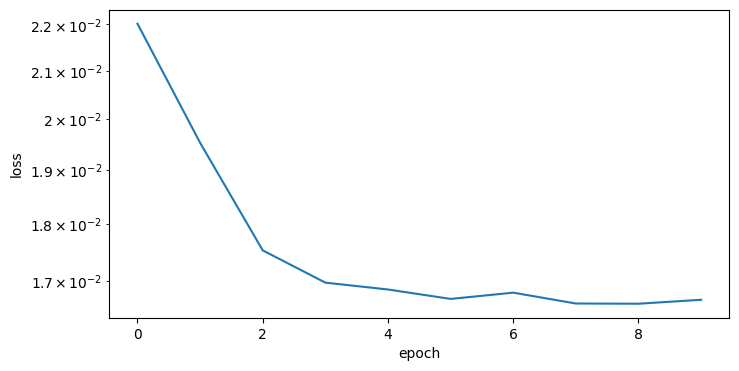

In [52]:
plt.figure(figsize=(8,4))
plt.semilogy(history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("loss")
model.save("model")

In [49]:
Yp=model.predict(X)

Yu=s2.inverse_transform(Yp)
Ym=s2.inverse_transform(Y)

655/655 [==============================] - 19s 27ms/step


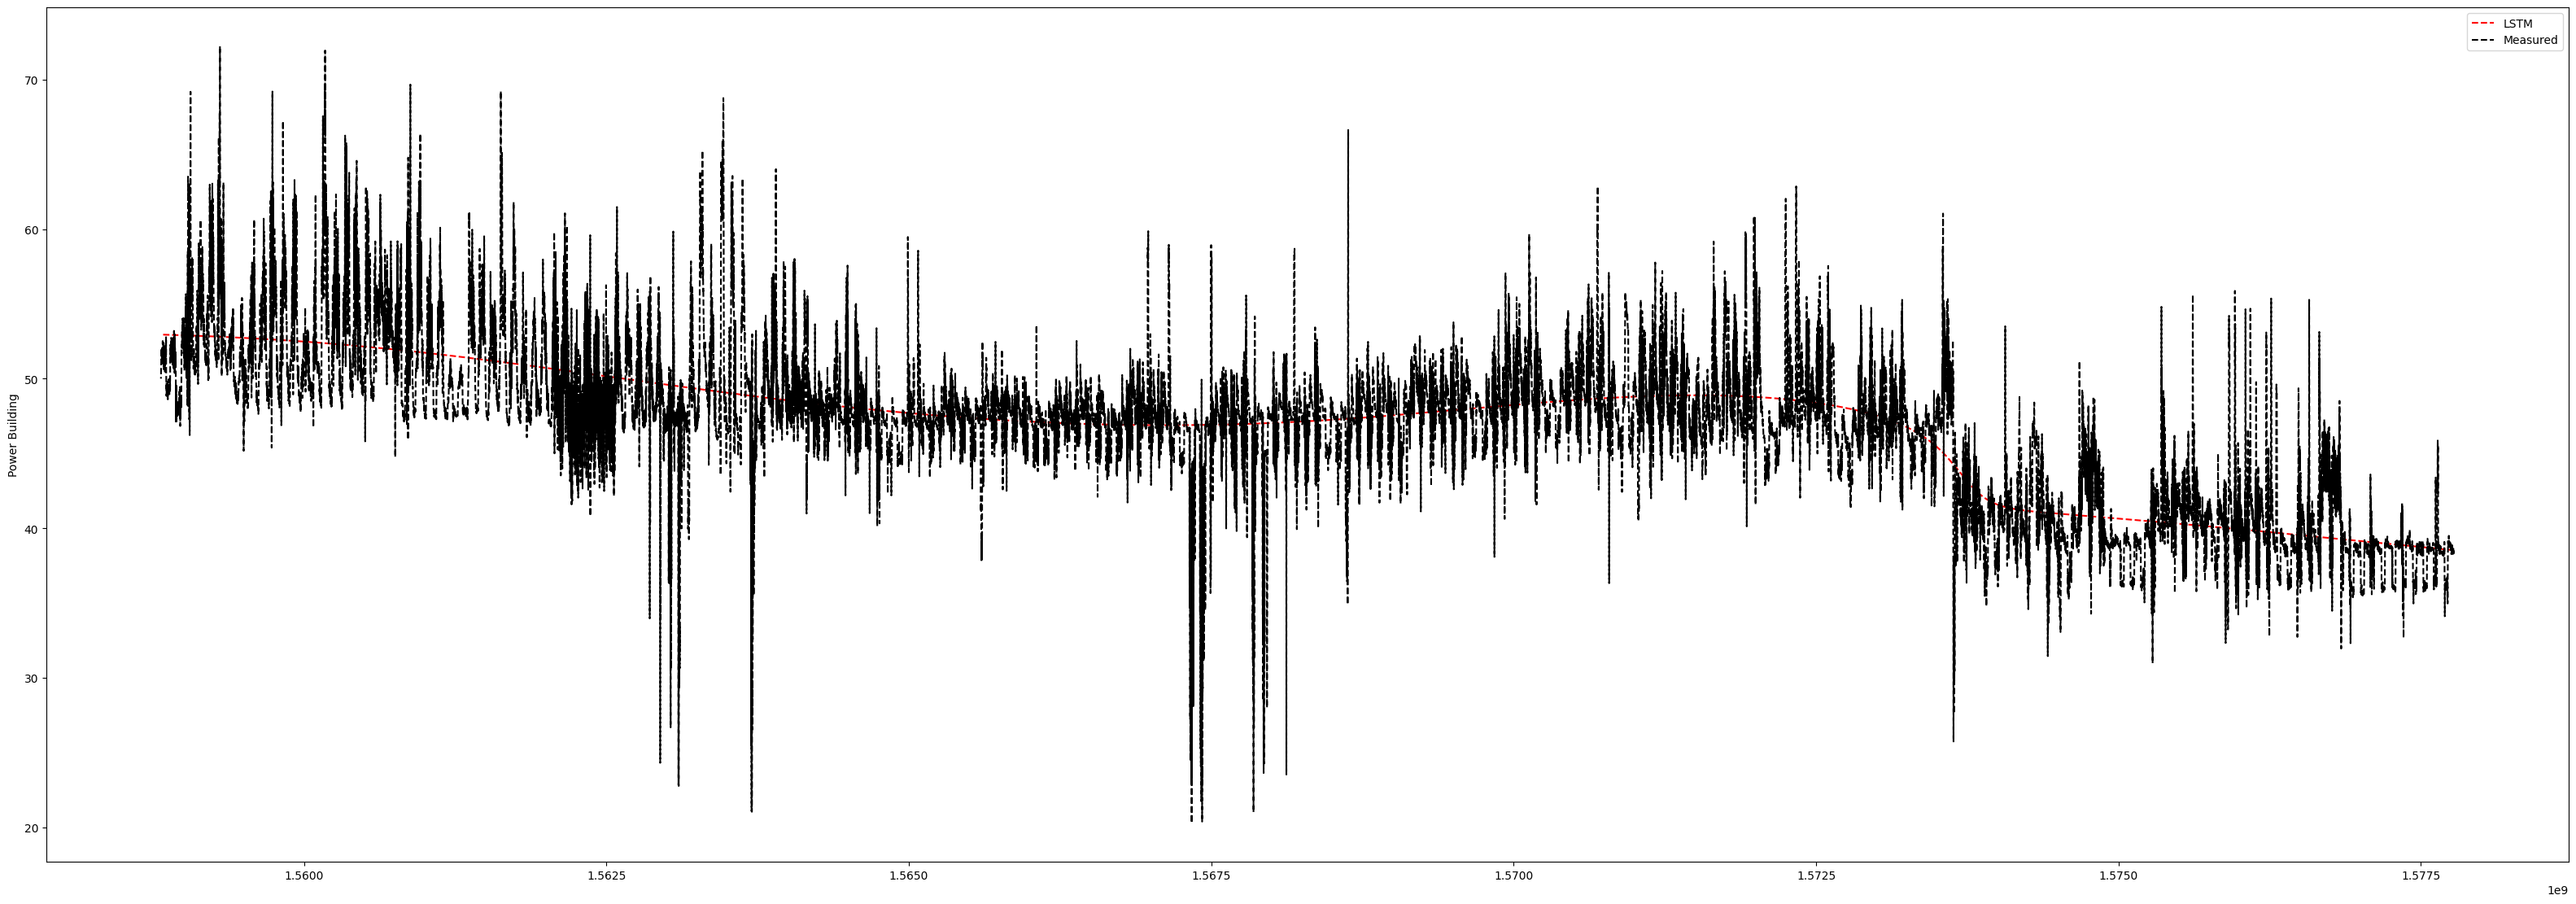

In [51]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(df["timestamp_numeric"][window:], Yu, "r--", label="LSTM")
plt.plot(df["timestamp_numeric"][window:], Ym, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()

In [53]:
v=load_model("model")

X_test_array = X_test.to_numpy()
Y_test_array = Y_test.to_numpy()

test = pd.DataFrame({'timestamp_numeric': X_test_array.flatten(), 'Power Building': Y_test_array.flatten()})

In [58]:
Xt=test[["timestamp_numeric"]].values
Yt=test[["Power Building"]].values

In [59]:
Xts=s1.transform(Xt)
Yts=s2.transform(Yt)

C:\Users\giuliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\giuliana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [63]:
Yti=[]
Xti=[]

for i in range(window, len (Xts)):
    Xti.append(Xts[i-window:i,:])
    Yti.append(Yts[i])

Xti,Yti=np.array(Xti), np.array(Yti)

In [65]:
Ytp=model.predict(Xti)

Ytu=s2.inverse_transform(Ytp)
Ytm=s2.inverse_transform(Yti)

162/162 [==============================] - 7s 41ms/step


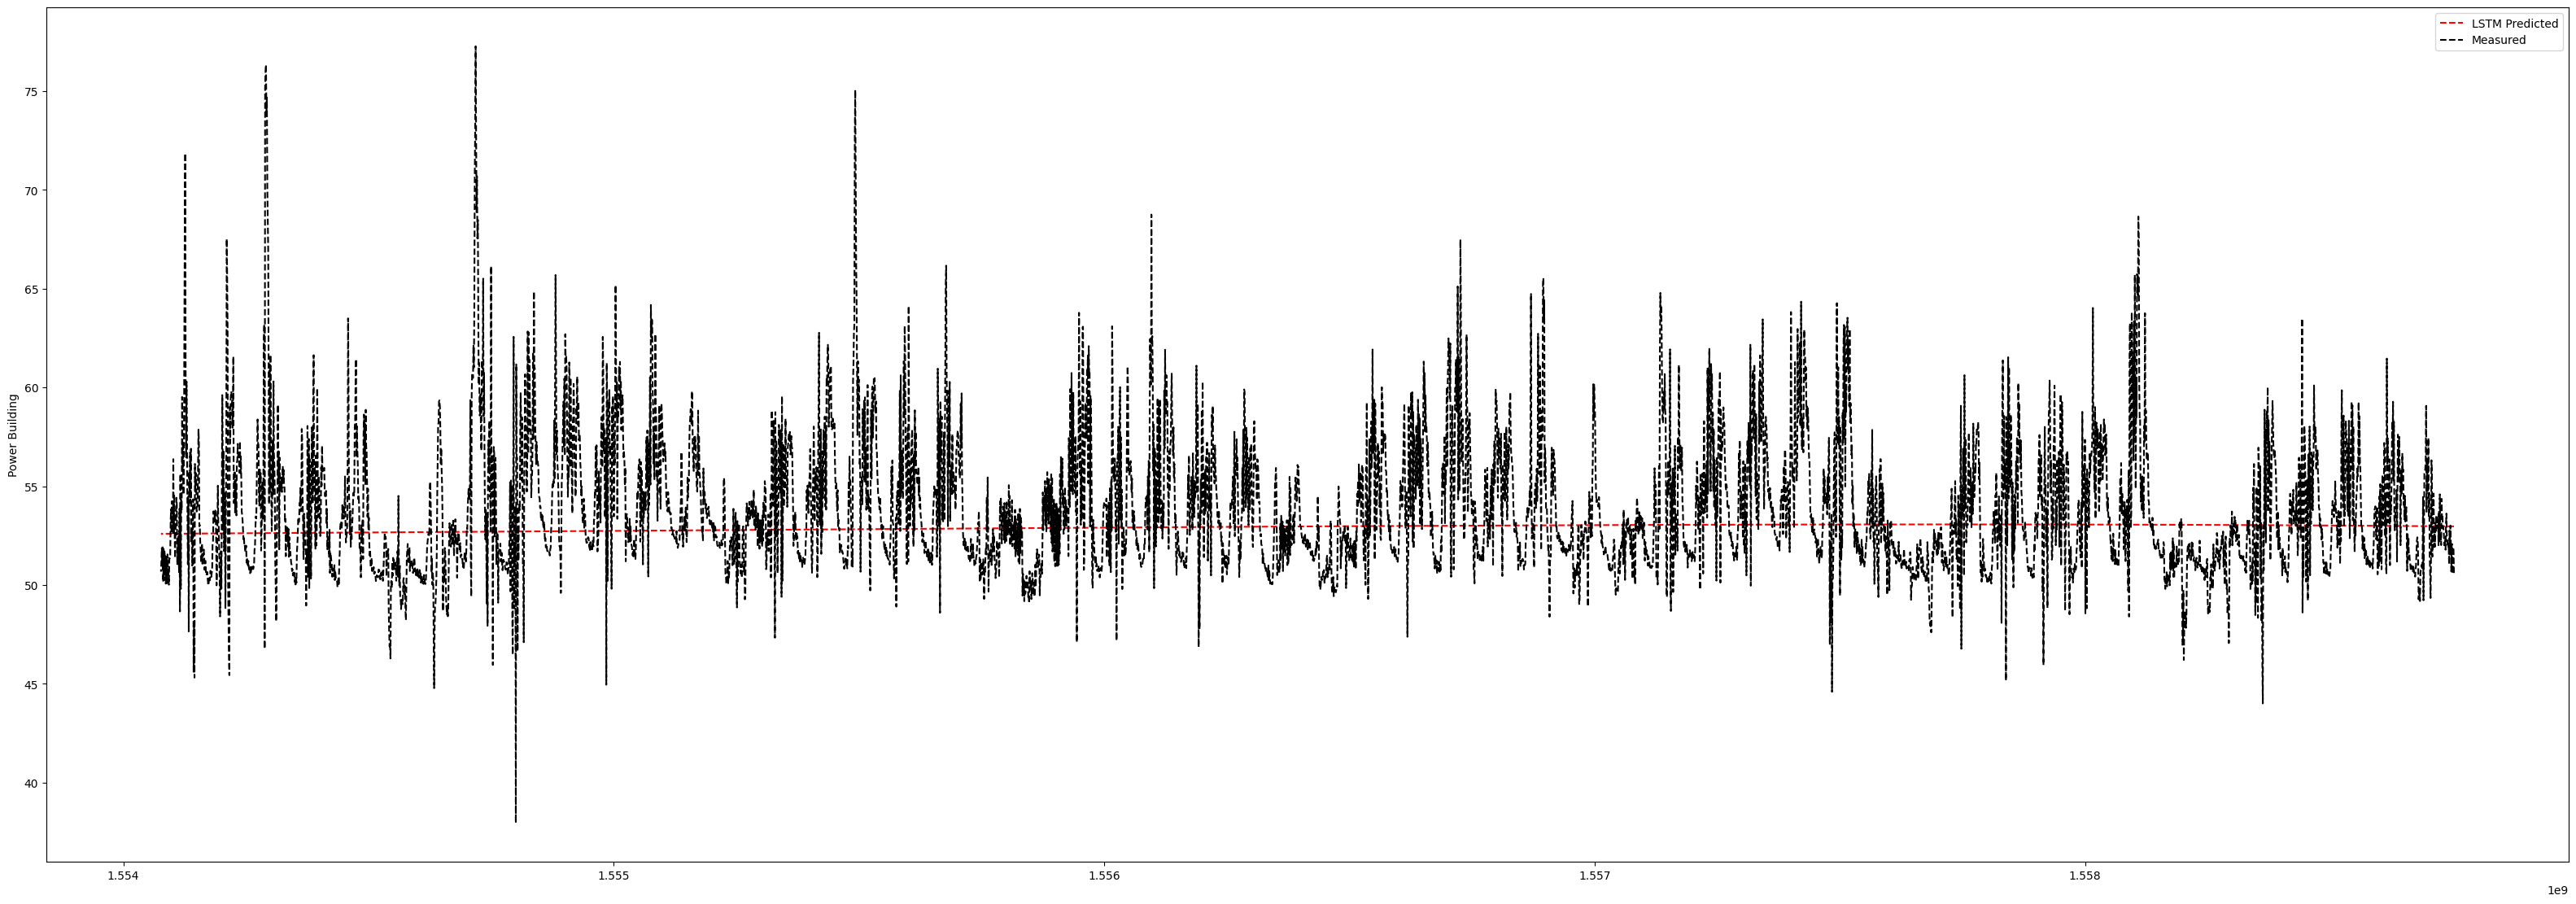

In [66]:
plt.figure(figsize=(40,30))
plt.subplot(2,1,1)
plt.plot(test["timestamp_numeric"][window:], Ytu, "r--", label="LSTM Predicted")
plt.plot(test["timestamp_numeric"][window:], Ytm, "k--", label="Measured")
plt.ylabel("Power Building")
plt.legend()